In [20]:
# neatness of code:
%load_ext pycodestyle_magic
%pycodestyle_on

In [86]:
# Packages:
import os
import sqlite3
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.feature_selection import f_regression, mutual_info_regression
import matplotlib.pyplot as plt

READ DATASET

In [62]:
# First que list all objects in the database:
db = '/home/ferran/Desktop/master/RI/ml/'\
   'final_project_skeleton/gdp_growth_forecast/db.sqlite3'
conn = sqlite3.connect(db)
pd.read_sql(""" SELECT * FROM sqlite_master;""", conn)
# load tables:
long = pd.read_sql("""SELECT * FROM CountryIndicators;""", conn)
# Not countries
exclude_list = ['Arab World', 'Caribbean small states',
                'Central Europe and the Baltics',
                'East Asia & Pacific (all income levels',
                'East Asia & Pacific (developing only', 'Euro area',
                'Europe & Central Asia (all income levels',
                'Europe & Central Asia (developing only', 'European Union',
                'Fragile and conflict affected situations',
                'Heavily indebted poor countries (HIPC', 'High income',
                'High income: nonOECD', 'High income: OECD',
                'Latin America & Caribbean (all income levels',
                'Latin America & Caribbean (developing only',
                'Least developed countries: UN classification',
                'Low & middle income',
                'Low income', 'Lower middle income',
                'Middle East & North Africa (all income levels',
                'Middle East & North Africa (developing only',
                'Middle income', 'North America', 'OECD members',
                'Other small states', 'Pacific island small states',
                'Small states', 'South Asia',
                'Sub-Saharan Africa (all income levels',
                'Sub-Saharan Africa (developing only', 'Upper middle income',
                'World', 'North America', 'OECD members']
# LongName to CountryName
country_names = pd.read_sql("""SELECT * FROM Countries;""", conn)
not_country = country_names.loc[country_names["LongName"].isin(exclude_list)]["CountryCode"]
long = long.loc[~ long["CountryCode"].isin(not_country)]
long

,CountryCode,IndicatorCode,Year,Value
228,EAS,SP.ADO.TFRT,1960,6.601597e+01
229,EAS,SP.POP.DPND,1960,7.643392e+01
230,EAS,SP.POP.DPND.OL,1960,6.828242e+00
231,EAS,SP.POP.DPND.YG,1960,6.923033e+01
232,EAS,NV.AGR.TOTL.KD,1960,1.241655e+11
...,...,...,...,...
5026216,ZWE,SP.URB.TOTL.IN.ZS,2010,3.319600e+01
5026217,ZWE,SP.URB.GROW,2010,1.279630e+00
5026218,ZWE,DT.DOD.DIMF.CD,2010,5.287290e+08
5026219,ZWE,SN.ITK.VITA.ZS,2010,4.930002e+01


33:80: E501 line too long (92 > 79 characters)


In [ ]:
TRANSFORM DATABASE TO WIDE FORMAT

In [64]:
df = long.pivot_table(index=['CountryCode', 'Year'],
                      columns='IndicatorCode', values='Value', aggfunc=np.sum)
df['Country'] = df.index.get_level_values(0)
df.columns = df.columns.str.replace(".", "_")
df

IndicatorCode     AG_AGR_TRAC_NO  AG_CON_FERT_PT_ZS  AG_CON_FERT_ZS  \
CountryCode Year                                                      
ABW         1960             NaN                NaN             NaN   
            1961             NaN                NaN             NaN   
            1962             NaN                NaN             NaN   
            1963             NaN                NaN             NaN   
            1964             NaN                NaN             NaN   
...                          ...                ...             ...   
ZWE         2006             NaN         210.442742       32.356341   
            2007             NaN         171.109177       27.035250   
            2008             NaN         147.903481       21.994118   
            2009             NaN         186.693038       28.778049   
            2010             NaN         215.715190       34.083000   

IndicatorCode     AG_LND_AGRI_K2  AG_LND_AGRI_ZS  AG_LND_ARBL_HA  \
CountryCode Year                                                   
ABW         1960             NaN             NaN             NaN   
            1961            20.0       11.111111          2000.0   
            1962            20.0       11.111111          2000.0   
            1963            20.0       11.111111          2000.0   
            1964            20.0       11.111111          2000.0   
...                          ...             ...             ...   
ZWE         2006        163000.0       42.135195       4100000.0   
            2007        162000.0       41.876696       4000000.0   
            2008        164500.0       42.522942       4250000.0   
            2009        163000.0       42.135195       4100000.0   
            2010        162000.0       41.876696       4000000.0   

IndicatorCode     AG_LND_ARBL_HA_PC  AG_LND_ARBL_ZS  AG_LND_CREL_HA  \
CountryCode Year                                                      
ABW         1960                NaN             NaN             NaN   
            1961           0.036078       11.111111             NaN   
            1962           0.035571       11.111111             NaN   
            1963           0.035275       11.111111             NaN   
            1964           0.035070       11.111111             NaN   
...                             ...             ...             ...   
ZWE         2006           0.312311       10.598423       2289312.0   
            2007           0.300802       10.339925       1949453.0   
            2008           0.314921       10.986170       2235440.0   
            2009           0.298812       10.598423       2080405.0   
            2010           0.286248       10.339925       1891766.0   

IndicatorCode     AG_LND_CROP_ZS  ...  per_lm_alllm_adq_pop_tot  \
CountryCode Year                  ...                             
ABW         1960             NaN  ...                       NaN   
            1961             NaN  ...                       NaN   
            1962             NaN  ...                       NaN   
            1963             NaN  ...                       NaN   
            1964             NaN  ...                       NaN   
...                          ...  ...                       ...   
ZWE         2006        0.258498  ...                       NaN   
            2007        0.258498  ...                       NaN   
            2008        0.258498  ...                       NaN   
            2009        0.258498  ...                       NaN   
            2010        0.258498  ...                       NaN   

IndicatorCode     per_lm_alllm_ben_q1_tot  per_lm_alllm_cov_pop_tot  \
CountryCode Year                                                      
ABW         1960                      NaN                       NaN   
            1961                      NaN                       NaN   
            1962                      NaN                       NaN   
            1963                      Na

LINEAR MIXED MODEL
We found out that the model is a random noise: We can explain Y (NY_GDP_MKTP_KD_ZG) using the same variable for the past year (Y_{t-1}). If we try to explain Y with both: Y_{t-1} and Y_{t-2} then the latter is non-significant. That means we have an autoregressive model of order 1. In the model below, you can see how lag1 (Y_{t-1}) is significant.

In [104]:
# Creation of covariables for the linear model.
df['lag1'] = df['NY_GDP_MKTP_KD_ZG'].shift(1)
df['Time'] = df.index.get_level_values(1)
df = df.dropna(subset=["NY_GDP_MKTP_KD_ZG", "lag1"])
# Countries strings to numeric values:
groups = df[["Country"]].replace(pd.unique(df.Country),
                                 list(range(0, len(pd.unique(df.Country)))))
groups = pd.to_numeric(groups.Country)
# mixed linear model with group as random effect.
df_sub = df[["NY_GDP_MKTP_KD_ZG", "Country", "lag1"]]
md = smf.mixedlm("NY_GDP_MKTP_KD_ZG ~ lag1", df_sub, groups=groups)
mod = md.fit()
df['residuals'] = mod.resid
df['Country'] = groups
mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: NY_GDP_MKTP_KD_ZG
No. Observations: 7954    Method:             REML             
No. Groups:       216     Scale:              39.9496          
Min. group size:  1       Log-Likelihood:     -26032.4988      
Max. group size:  49      Converged:          Yes              
Mean group size:  36.8                                         
-----------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept     2.928      0.114   25.670   0.000    2.705    3.152
lag1          0.271      0.011   23.933   0.000    0.249    0.294
Group Var     1.169      0.039                                   
===============================================================

"""

Text(0.5, 1.0, 'NY_GDP_MKTP_KD_ZG: Random noise')

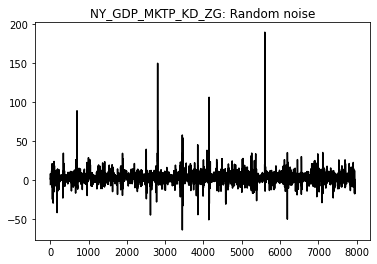

In [106]:
plt.plot(df['NY_GDP_MKTP_KD_ZG'].to_numpy(), 'b', color='black')
plt.title("NY_GDP_MKTP_KD_ZG: Random noise", loc='center')

FEATURE SELECTION
The mutual information between two random variables is a non-negative value that measures the dependencies between variables. The mutual information between independent random variables is equal to 0, and the larger the mutual information, the stronger the dependency. This function relies on the nonparametric method of entropy estimation based on k-nearest neighbor distance.

In [92]:
# Filter/impute vars with NA
df_fewNA = df[df.columns[(df.isnull().sum(axis=0)/df.shape[0] <= 0.3)]]
country2 = df_fewNA['Country']
df_fewNA = df_fewNA.groupby(country2).transform(
    lambda x: x.fillna(x.ffill().bfill()))
df_fewNA = df_fewNA.fillna(df.mean())
df_fewNA["Country"] = country2
# Feature selection
covs = df_fewNA.drop(["NY_GDP_MKTP_KD_ZG", "residuals"], 1)
Y = df_fewNA[['residuals']]
info = mutual_info_regression(covs, np.ravel(Y))
df_varimp = pd.DataFrame(data={'name': covs.columns, 'varimp': info})
# Keep top50
selected_variables = df_varimp.sort_values(by="varimp",
                                           ascending=False)[0:49]
selected_variables['name'] = selected_variables['name'].str.replace('_', '.')

In [ ]:
FETAURE SELECTION: NAMES OF FINAL VARIABLES

In [114]:
# Definition of variables: sql: Indicators
db = '/home/ferran/Desktop/master/RI/ml/final_project_skeleton/db.sqlite3'
conn = sqlite3.connect(db)
list_of_entries_to_retrive = (selected_variables['name']).tolist()
queryString = 'SELECT IndicatorCode,LongDefinition FROM Indicators WHERE IndicatorCode IN (\'{}\');'.format(
    '\',\''.join([_ for _ in list_of_entries_to_retrive]))
vars_definition = pd.read_sql(queryString, con=conn)
vars_definition = vars_definition.append(pd.DataFrame(
    data={'IndicatorCode': ["lag1", "Country", "Time"],
          'LongDefinition': ["lag1", "Country", "Time"]}), ignore_index=True)
vars_definition = vars_definition.sort_values(by="IndicatorCode")
# bind cols
selected_variables = selected_variables.sort_values(by="name")
if selected_variables['name'].tolist() == vars_definition['IndicatorCode'].tolist():
    selected_variables["LongDefinition"] = vars_definition['LongDefinition'].tolist()
pd.set_option('display.max_colwidth', -1)
selected_variables

<ipython-input-114-c741e3ae1d21>:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,name,varimp,LongDefinition
1,AG.LND.AGRI.ZS,0.041240,"Agricultural land refers to the share of land area that is arable, under permanent crops, and under permanent pastures. Arable land includes land defined by the FAO as land under temporary crops (double-cropped areas are counted once), temporary meadows for mowing or for pasture, land under market or kitchen gardens, and land temporarily fallow. Land abandoned as a result of shifting cultivation is excluded. Land under permanent crops is land cultivated with crops that occupy the land for long periods and need not be replanted after each harvest, such as cocoa, coffee, and rubber. This category includes land under flowering shrubs, fruit trees, nut trees, and vines, but excludes land under trees grown for wood or timber. Permanent pasture is land used for five or more years for forage, including natural and cultivated crops."
3,AG.LND.ARBL.HA.PC,0.042316,"Arable land (hectares per person) includes land defined by the FAO as land under temporary crops (double-cropped areas are counted once), temporary meadows for mowing or for pasture, land under market or kitchen gardens, and land temporarily fallow. Land abandoned as a result of shifting cultivation is excluded."
8,AG.PRD.CREL.MT,0.041872,"Production data on cereals relate to crops harvested for dry grain only. Cereal crops harvested for hay or harvested green for food, feed, or silage and those used for grazing are excluded."
207,Country,0.045295,Country
16,DC.DAC.DEUL.CD,0.044701,"Net bilateral aid flows from DAC donors are the net disbursements of official development assistance (ODA) or official aid from the members of the Development Assistance Committee (DAC). Net disbursements are gross disbursements of grants and loans minus repayments of principal on earlier loans. ODA consists of loans made on concessional terms (with a grant element of at least 25 percent, calculated at a rate of discount of 10 percent) and grants made to promote economic development and welfare in countries and territories in the DAC list of ODA recipients. Official aid refers to aid flows from official donors to countries and territories in part II of the DAC list of recipients: more advanced countries of Central and Eastern Europe, the countries of the former Soviet Union, and certain advanced developing countries and territories. Official aid is provided under terms and conditions similar to those for ODA. Part II of the DAC List was abolished in 2005. The collection of data on official aid and other resource flows to Part II countries ended with 2004 data. DAC members are Australia, Austria, Belgium, Canada, Czech Republic, Denmark, Finland, France, Germany, Greece, Iceland, Ireland, Italy, Japan, Republic of Korea, Luxembourg, Netherlands, New Zealand, Norway, Poland, Portugal, Slovak Republic, Slovenia, Spain, Sweden, Switzerland, United Kingdom, United States, and European Union Institutions. Regional aggregates include data for economies not specified elsewhere. World and income group totals include aid not allocated by country or region. Data are in current U.S. dollars."
17,DC.DAC.JPNL.CD,0.053308,"Net bilateral aid flows from DAC donors are the net disbursements of official development assistance (ODA) or official aid from the members of the Development Assistance Committee (DAC). Net disbursements are gross disbursements of grants and loans minus repayments of principal on earlier loans. ODA consists of loans made on concessional terms (with a grant element of at least 25 percent, calculated at a rate of discount of 10 percent) and grants made to promote economic development and welfare in countries and territories in the DAC list of ODA recipients. Official aid refers to aid flows from official donors to countries and territories in part II of the DAC list of recipients: more advanced countries of Central and Eastern Europe, the countries of the former Soviet Union, and certain advanced developing countries and territories. Offici

5:80: E501 line too long (108 > 79 characters)
14:80: E501 line too long (84 > 79 characters)
15:80: E501 line too long (85 > 79 characters)


Text(0.5, 1.0, 'Measured importance')

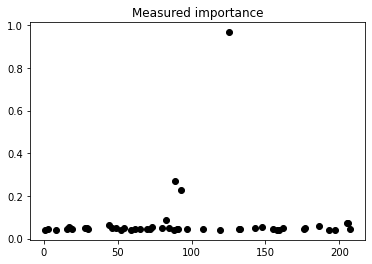

In [115]:
plt.plot(selected_variables['varimp'], 'o', color='black')
plt.title("Measured importance", loc='center')